In [1]:
## Hidden Cells
#
#from IPython.display import HTML
#
#HTML('''<script>
#code_show=true; 
#function code_toggle() {
# if (code_show){
# $('div.input').hide();
# } else {
# $('div.input').show();
# }
# code_show = !code_show
#} 
#$( document ).ready(code_toggle);
#</script>
#<form action="javascript:code_toggle()"></form>''')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries 

In [3]:
!pip install imagecodecs

     |████████████████████████████████| 30.0MB 98kB/s 


In [4]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [5]:
from skimage.io import imread, imshow, imsave
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_otsu
from skimage.filters.rank import median
from skimage.morphology import disk
from skimage.transform import resize

%matplotlib inline

import os
import shutil

from tqdm import tqdm_notebook as tqdm
import pandas as pd

from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow import keras
from tensorflow.keras import layers

import imagecodecs as ic

# Variables

In [6]:
threshold_to_255 = 215

generalPath = '/content/drive/MyDrive/Offline-Signature-Verification-Project/'.replace('/', os.sep)
datasetName = 'UTSig 10'

img_width = 128
img_height = 128

# Functions

In [7]:
def delimitImage(image):
    
    '''
    Author: Fred Morales
    Description: Generates a delimited image
    Parameters:
        image.- array in gray-scale (0-255)
        
    Return: array delimited
    '''
    
    boolean_version = image == 255

    topLimit, leftLimit, rightLimit, bottomLimit = -1,-1,-1,-1

    for i in range(boolean_version.shape[0]):

        if any([False in boolean_version[i]]):

            topLimit = i
            break

    for i in range(boolean_version.shape[0]-1,0,-1):

        if any([False in boolean_version[i]]):

            bottomLimit = i
            break

    for i in range(boolean_version.shape[1]):

        if any([False in boolean_version[:,i]]):

            leftLimit = i
            break

    for i in range(boolean_version.shape[1]-1,0,-1):

        if any([False in boolean_version[:,i]]):

            rightLimit = i
            break
            
    return image[topLimit:bottomLimit, leftLimit:rightLimit]

# Load image

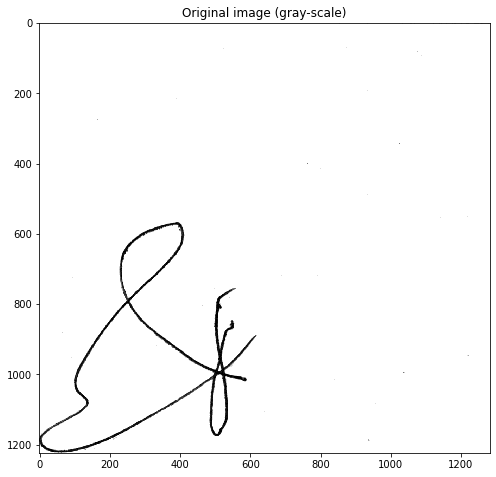

In [8]:
image_gray = ic.imread(generalPath + '12.tif')
#img_new = rgb2gray(img)
plt.figure(figsize=(7,7))
plt.title('Original image (gray-scale)')
imshow(image_gray)

In [9]:
# Image representation 

print('Size: ', image_gray.shape)
print('Data: ', image_gray)

Size:  (1224, 1282)
Data:  [[255 255 255 ... 153 187 187]
 [255 255 255 ... 221 221 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


# Preprocessing

### Example

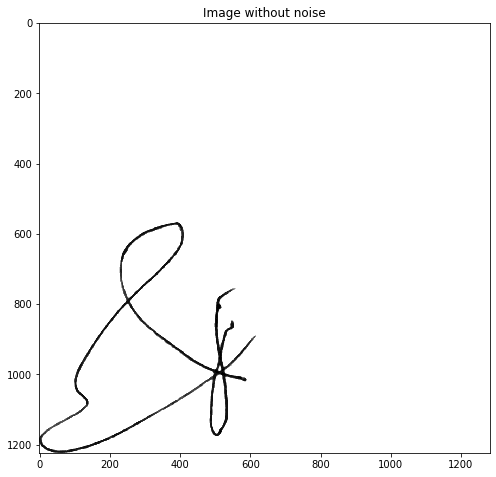

In [10]:
# The median filter is often used for noise removal because borders are preserved

image_Without_Noise = median(image_gray, disk(4))
image_Without_Noise = np.where(image_Without_Noise > threshold_to_255, 255, image_Without_Noise)

plt.figure(figsize=(7,7))
plt.title('Image without noise')
imshow(image_Without_Noise)

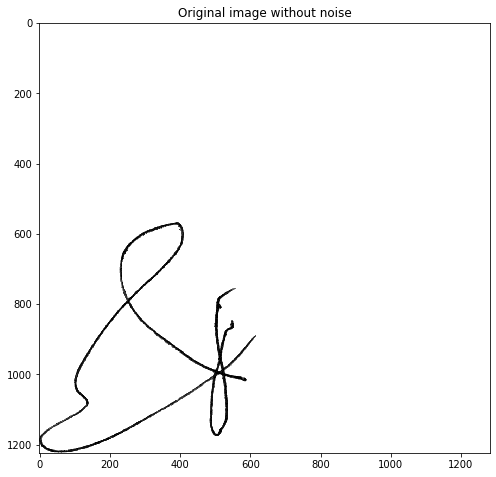

In [11]:
image_gray_without_noise = np.where(image_Without_Noise == 255, 255, image_gray)

plt.figure(figsize=(7,7))
plt.title('Original image without noise')
imshow(image_gray_without_noise)

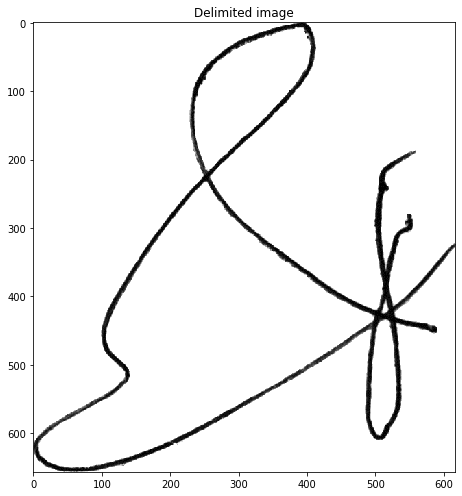

In [12]:
# Delimit the image

image_Without_Noise_delimited = delimitImage(image_gray_without_noise)
        
plt.figure(figsize=(7,7))
plt.title('Delimited image')
imshow(image_Without_Noise_delimited)

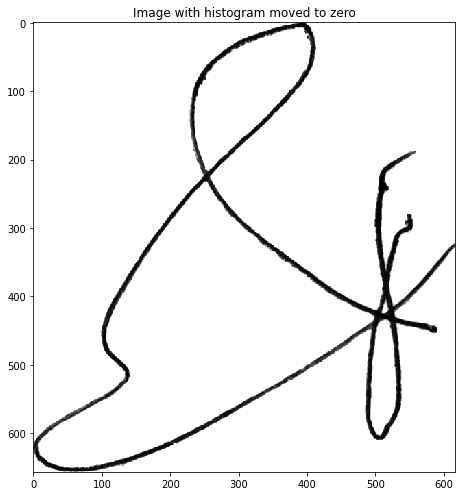

In [13]:
min_value = np.min(image_Without_Noise_delimited)

preprocessed_image = np.where(image_Without_Noise_delimited != 255
                              , image_Without_Noise_delimited - min_value
                              , image_Without_Noise_delimited)

plt.figure(figsize=(7,7))
plt.title('Image with histogram moved to zero')
imshow(preprocessed_image)

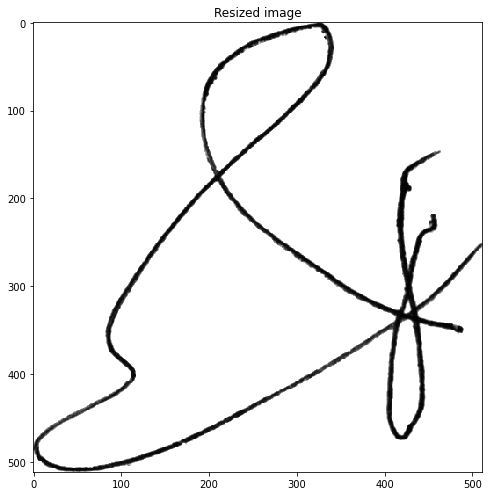

In [14]:
# Resized image

preprocessed_image = np.round(resize(preprocessed_image, (512, 512)) * 255).astype(np.uint8)
preprocessed_image = np.where(preprocessed_image > threshold_to_255, 255, preprocessed_image)

plt.figure(figsize=(7,7))
plt.title('Resized image')
imshow(preprocessed_image)

imsave(generalPath + 'preprocesing_12.png', preprocessed_image)

In [15]:
preprocessed_image

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [ ]:
# Image binarization

#threshold = threshold_otsu(image_Without_Noise_delimited)

#binary = image_Without_Noise_delimited > threshold

#binary = np.uint8(np.where(binary == True, 255, binary))

#plt.figure(figsize=(8,8))
#imshow(binary)

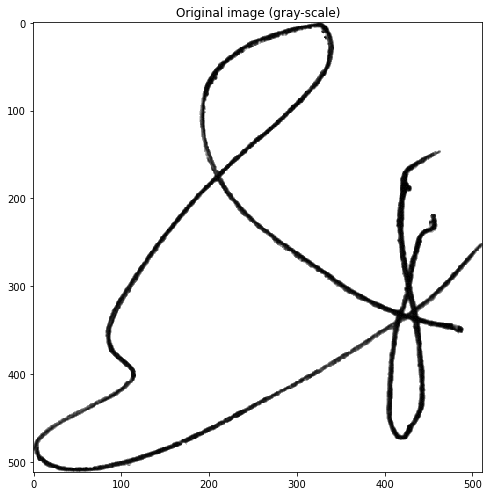

In [16]:
image_gray = imread(generalPath + 'preprocesing_12.png')
plt.figure(figsize=(7,7))
plt.title('Original image (gray-scale)')
imshow(image_gray)

In [17]:
image_gray

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

### Processing dataset

In [18]:
# Directory creation

modelsPath = generalPath + 'Model'
targetPath = generalPath + 'Dataset preprocessing'

UTSigPath = targetPath + os.sep + datasetName
UTSig_Genuine_Path = UTSigPath + os.sep + 'Genuine'
UTSig_Forgery_Path = UTSigPath + os.sep + 'Forgery'

total = 0

try:
        
    if not os.path.exists(targetPath):
        
        #shutil.rmtree(targetPath)
        os.mkdir(targetPath)

    if not os.path.exists(UTSigPath):

        os.mkdir(UTSigPath)
        os.mkdir(UTSig_Genuine_Path)
        os.mkdir(UTSig_Forgery_Path)

except OSError as error:
    print(error)
    
sourcePath = generalPath + os.sep.join(['Dataset', datasetName])

for root, directories, files in os.walk(sourcePath, topdown=False):
    for name in files:
        
        total += 1

In [20]:
# Preprocessing all dataset

UTSig_Forgery_Path_List = []
UTSig_Genuine_Path_List = []

isThereFile = False

for root, directories, files in os.walk(UTSigPath, topdown=False):
    if len(files) > 0:
        isThereFile = True
        break

if not isThereFile:

    totalProcessed = 0

    for root, directories, files in os.walk(sourcePath, topdown=False):
        
        for name in tqdm(files, desc ="Preprocessing image: "):
            
            pathImage = os.path.join(root, name)
            
            # Load image and convert gray-scale
            
            image_gray = ic.imread(pathImage)
            
            # Apply median filter
            
            image_Without_Noise = median(image_gray, disk(4))
            image_Without_Noise = np.where(image_Without_Noise > threshold_to_255, 255, image_Without_Noise)
            
            # Original imagen without noise
            
            image_gray_without_noise = np.where(image_Without_Noise == 255, 255, image_gray)
            
            # Delimit the image

            image_Without_Noise_delimited = delimitImage(image_gray_without_noise)
            
            # Image with histogram moved to zero
            
            min_value = np.min(image_Without_Noise_delimited)

            preprocessed_image = np.where(image_Without_Noise_delimited != 255
                                          , image_Without_Noise_delimited - min_value
                                          , image_Without_Noise_delimited)
            
            # Resized image

            preprocessed_image = np.round(resize(preprocessed_image, (512, 512)) * 255).astype(np.uint8)
            preprocessed_image = np.where(preprocessed_image > threshold_to_255, 255, preprocessed_image)
            
            # Save image
            
            pathImage = pathImage.replace('Dataset','Dataset preprocessing')
            
            listFolderName = pathImage.split(os.sep)

            if 'Genuine' in listFolderName:
                pathImage = os.sep.join(listFolderName[:-2]) + os.sep + '_'.join(listFolderName[-2:])
            else:
                pathImage = os.sep.join(listFolderName[:-3]) + os.sep + '_'.join(listFolderName[-3:])

            pathImage = os.path.splitext(pathImage)[0] + '.png'
            
            imsave(pathImage, preprocessed_image)

            totalProcessed += 1

        print('Total procesados: {} de {} ({} %)'.format(totalProcessed, total, round(totalProcessed / total * 100, 2)))

    UTSig_Forgery_Path_List = os.listdir(UTSig_Forgery_Path)
    UTSig_Genuine_Path_List = os.listdir(UTSig_Genuine_Path)

else:

    sourcePath = generalPath + os.sep.join(['Dataset', datasetName])

    for root, directories, files in os.walk(sourcePath, topdown=False):
        for name in files:
            
            pathTemp = os.path.join(root, name)

            listDirectories = pathTemp.split(os.sep)

            if 'Forgery' in pathTemp:

                fileName = '_'.join(listDirectories[-3:]).replace('tif','png')
                UTSig_Forgery_Path_List.append(fileName)

            else:

                fileName = '_'.join(listDirectories[-2:]).replace('tif','png')
                UTSig_Genuine_Path_List.append(fileName)

In [ ]:
dfForgery = pd.DataFrame([filename for filename in UTSig_Forgery_Path_List]
                         , columns=['filename'])
dfForgery['class'] = 0

dfGenuine = pd.DataFrame([filename for filename in UTSig_Genuine_Path_List]
                         , columns=['filename'])
dfGenuine['class'] = 1

df = pd.concat([dfForgery, dfGenuine], ignore_index = True)

y = df[['class']]

In [ ]:
df[['class']].value_counts()

class
0        450
1        270
dtype: int64

In [ ]:
df[['class']].value_counts() / df.shape[0]

class
0        0.625
1        0.375
dtype: float64

In [ ]:
df

,filename,class
0,Opposite Hand_1_1.png,0
1,Opposite Hand_1_2.png,0
2,Opposite Hand_1_3.png,0
3,Opposite Hand_10_1.png,0
4,Opposite Hand_10_2.png,0
...,...,...
715,9_5.png,1
716,9_6.png,1
717,9_7.png,1
718,9_8.png,1


In [ ]:
if not isThereFile:

    for filename in UTSig_Forgery_Path_List:
      
        shutil.move(os.path.join(UTSig_Forgery_Path, filename), UTSigPath)

    for filename in UTSig_Genuine_Path_List:
        
        shutil.move(os.path.join(UTSig_Genuine_Path, filename), UTSigPath)
        
    shutil.rmtree(UTSig_Genuine_Path)
    shutil.rmtree(UTSig_Forgery_Path)

# Building the CNN

In [ ]:
def create_model():
    model = keras.Sequential([
        layers.InputLayer(input_shape=[img_width, img_height, 1]),
        
        # Data Augmentation
        #preprocessing.RandomContrast(factor=0.10),
        #preprocessing.RandomFlip(mode='horizontal'),
        #preprocessing.RandomRotation(factor=0.10),

        # Block One
        layers.BatchNormalization(renorm=True),
        layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPool2D(),

        # Block Two
        layers.BatchNormalization(renorm=True),
        layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPool2D(),

        # Block Three
        #layers.BatchNormalization(renorm=True),
        #layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
        #layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
        #layers.MaxPool2D(),

        # Optional: Using Dropout and Batch Normalization

        # Add dropout to control overfitting and 
        # batch normalization to speed up optimization

        # layers.Dense(1024, activation='relu'),
        # layers.Dropout(0.3),
        # layers.BatchNormalization(),
        # layers.Dense(1024, activation='relu'),
        # layers.Dropout(0.3),
        # layers.BatchNormalization(),
        # layers.Dense(1),

        # Head
        layers.BatchNormalization(renorm=True),
        layers.Flatten(),
        #layers.Dense(256, activation='relu'),
        #layers.Dropout(0.5),
        #layers.BatchNormalization(),
        layers.Dense(8, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid'),
    ])
    
    optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['binary_accuracy'],
    )
    
    return model

Found 576 validated image filenames.
Found 144 validated image filenames.



################## Models architecture ##################

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 128, 128, 1)       7         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)    

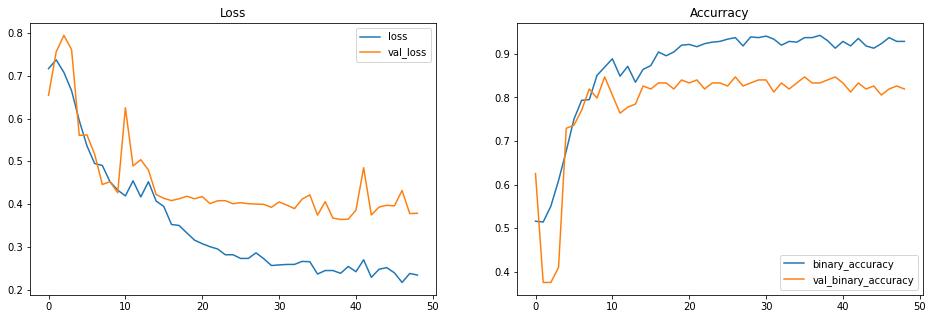

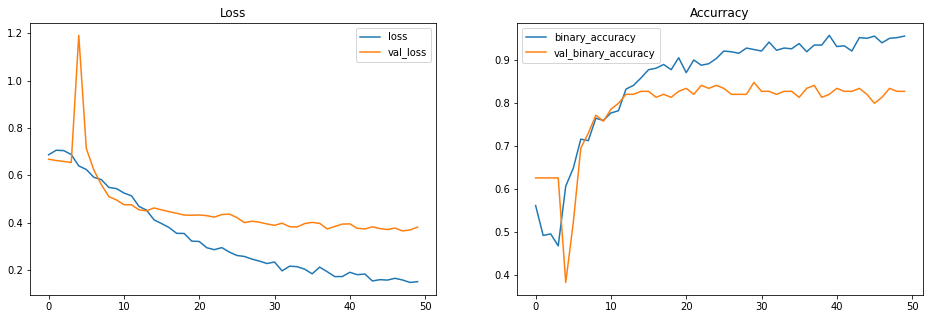

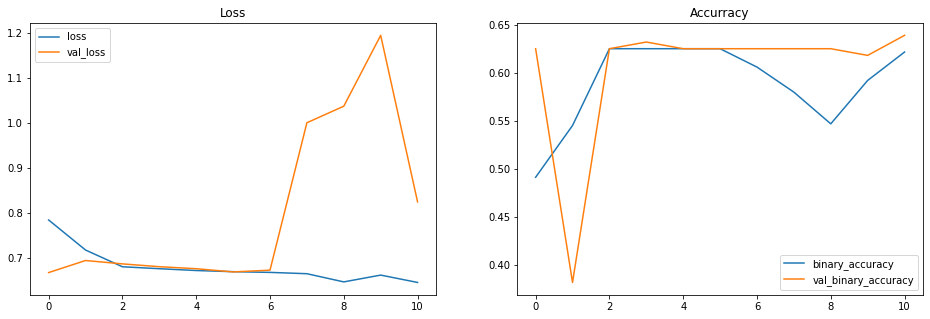

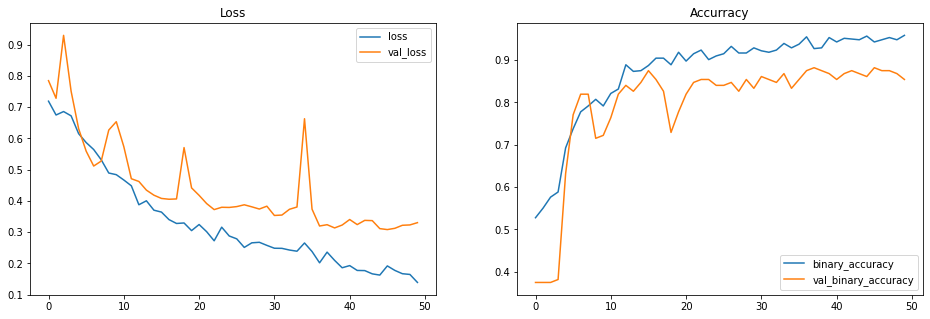

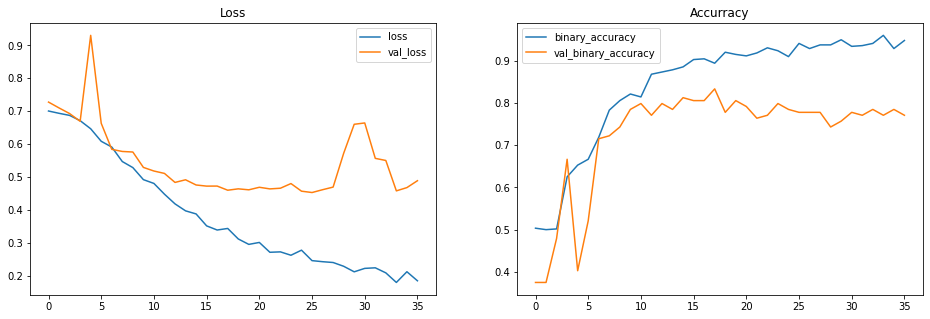

In [ ]:
TRAIN_ACCURACY = []
TRAIN_LOSS = []

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

fold = 1

showArchitecture = True

#kf = KFold(n_splits = 5)
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 7)
idg = ImageDataGenerator(rescale=1 / 255.0)

tf.keras.backend.clear_session()

for train_index, validation_index in skf.split(np.zeros(y.shape[0]), y):

    training_data = df.iloc[train_index]
    validation_data = df.iloc[validation_index]
    
    train_data_generator = idg.flow_from_dataframe(training_data, directory = UTSigPath,
                                                   x_col = 'filename', y_col = 'class',
                                                   class_mode = 'raw', shuffle = True, 
                                                   color_mode='grayscale', target_size=(img_width, img_height))
    
    validation_data_generator  = idg.flow_from_dataframe(validation_data, directory = UTSigPath,
                                                         x_col = 'filename', y_col = 'class',
                                                         class_mode = 'raw', shuffle = True, 
                                                         color_mode='grayscale', target_size=(img_width, img_height))
    
    ######## Building model ########

    model = create_model()

    ######## Displaying the model's architecture ########

    if(showArchitecture):
        showArchitecture = False
        print('\n')
        print('\n################## Model''s architecture ##################\n'.format(fold))
        model.summary()
        print('\n')

    print('\n##############################################')
    print('################### Fold #{} ##################'.format(fold))
    print('##############################################\n')

    ######## Adding Early Stopping ########

    # These parameters say: "If there hasn't been at least an improvement of 0.001 in the validation 
    # loss over the previous 10 epochs, then stop the training and keep the best model you found."

    early_stopping = keras.callbacks.EarlyStopping(
        patience=10, # how many epochs to wait before stopping
        min_delta=0.001, # minimium amount of change to count as an improvement
        restore_best_weights=True,
    )

    ######## Saving Model ########

    # Create a callback that saves the model's weights

    checkpoint_path = modelsPath + os.sep +'cp.ckpt'

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                      verbose=1,
                                                      monitor='val_binary_accuracy',
                                                      mode='max',
                                                      save_best_only=True)

    ######## Creating callbacks list ########

    callbacks_list = [early_stopping, cp_callback]

    ######## Fitting the model ########

    history = model.fit(
        train_data_generator,
        validation_data=validation_data_generator,
        batch_size=128,
        epochs=50,
        callbacks=callbacks_list
    )
    
    ######## Plotting losses ########

    history_df = pd.DataFrame(history.history)
    ##print(history_df.columns.tolist())
    #history_df.loc[:, ['loss', 'val_loss']].plot()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

    axes[0].plot(history_df.loc[:, 'loss'], label='loss')
    axes[0].plot(history_df.loc[:, 'val_loss'], label='val_loss')
    axes[0].set_title('Loss')
    axes[0].legend()

    axes[1].plot(history_df.loc[:, 'binary_accuracy'], label='binary_accuracy')
    axes[1].plot(history_df.loc[:, 'val_binary_accuracy'], label='val_binary_accuracy')
    axes[1].set_title('Accurracy')
    axes[1].legend()
    
    ######## Load best model ########

    model.load_weights(checkpoint_path).expect_partial()
    
    ######## Evaluating the model ########

    # with train data

    results = model.evaluate(train_data_generator)
    results = dict(zip(model.metrics_names, results))
    TRAIN_ACCURACY.append(results['binary_accuracy'])
    TRAIN_LOSS.append(results['loss'])

    # with validation data

    results = model.evaluate(validation_data_generator)
    results = dict(zip(model.metrics_names, results))
    VALIDATION_ACCURACY.append(results['binary_accuracy'])
    VALIDATION_LOSS.append(results['loss'])

    tf.keras.backend.clear_session()

    fold += 1

In [ ]:
TRAIN_ACCURACY

[0.9739583134651184,
 0.9965277910232544,
 0.625,
 0.9965277910232544,
 0.9947916865348816]

In [ ]:
TRAIN_LOSS

[0.25543656945228577,
 0.1425161063671112,
 0.6640752553939819,
 0.10487765073776245,
 0.24077433347702026]

In [ ]:
VALIDATION_ACCURACY

[0.8472222089767456,
 0.8472222089767456,
 0.625,
 0.8819444179534912,
 0.8333333134651184]

In [ ]:
VALIDATION_LOSS

[0.42649632692337036,
 0.39414337277412415,
 0.6670506000518799,
 0.3239395320415497,
 0.45991605520248413]

In [ ]:
# Fake signature detection example

model = create_model()
model.load_weights(checkpoint_path).expect_partial()

img = keras.preprocessing.image.load_img(
    generalPath + os.sep.join(['Dataset preprocessing', datasetName, 'Opposite Hand_1_1.png'])
    , target_size=(img_width, img_height, 1)
    , color_mode="grayscale"
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

img_array = img_array / 255.0

predictions = model.predict(img_array)
print(predictions)

[[0.]]


In [ ]:
# Genuine signature detection example 

img = keras.preprocessing.image.load_img(
    generalPath + os.sep.join(['Dataset preprocessing', datasetName, '1_1.png'])
    , target_size=(img_width, img_height, 1)
    , color_mode="grayscale"
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

img_array = img_array / 255.0

predictions = model.predict(img_array)
print(predictions)

[[0.]]
